In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import neuron
from neuron import h
import numba
import time, os
import subprocess
import pickle, glob
import scipy.signal
from scipy.signal import find_peaks
import copy

def calcSpikeTime_spikeIndex_FiringRate_spikeNumber_fromVth(vsoma, tvar, Vth=0.0):
    '''Calculate the discharge rate, discharge time and index. The discharge time is defined as the moment when vsoma exceeds Vth.'''
    logicArray = vsoma >= 0.0
    logicArray_binary = logicArray.astype(np.int32)
    logicArray_diff   = np.hstack((0, np.diff(logicArray_binary)))
    spikeIndex  = logicArray_diff > 0.0
    spikeTime   = tvar[spikeIndex]
    spikeNumber = np.sum(spikeIndex)
    firingRate  = 1000 * spikeNumber / (tvar[-1] - tvar[0])
    spikeIndex  = np.nonzero(spikeIndex)[0]
    return spikeTime, spikeIndex, firingRate, spikeNumber

def calc_field_spike_entrainment(vsoma=np.zeros(10), Evar=np.zeros(10), tvar=np.zeros(10), Vth=0.0):
    '''Using the Hilbert transform, 0° corresponds to the peak of the electric field waveform, and 90° corresponds to the edge of the electric field decline.'''
    analyticSignal = scipy.signal.hilbert(Evar)
    tacsInstantaneousPhase = np.angle(analyticSignal)  # -π~π
    spikeTime, spikeIndex, firingRate, spikeNumber = calcSpikeTime_spikeIndex_FiringRate_spikeNumber_fromVth(vsoma, tvar, Vth=Vth)
    spikePhaseRadian = tacsInstantaneousPhase[spikeIndex]
    spikePhaseRadian[spikePhaseRadian < 0 ] += 2*np.pi
    pluralPLV = np.mean(np.exp(1j*spikePhaseRadian))
    spikePhaseDegree = np.rad2deg(spikePhaseRadian)
    fieldSpikePLV = np.abs(pluralPLV)

    return fieldSpikePLV, spikePhaseDegree, pluralPLV, spikeTime, spikeIndex, firingRate, spikeNumber

def calc_uniformE_theta_phi(allSectionLists, theta=0, phi=0):
    theta = theta * np.pi / 180
    phi   = phi * np.pi / 180
    Ex = np.sin(theta) * np.cos(phi)
    Ey = np.sin(theta) * np.sin(phi)
    Ez = np.cos(theta)
    for sec in allSectionLists:
        if h.ismembrane('xtra', sec=sec) and h.ismembrane('extracellular', sec=sec):
            for seg in sec:
                # The unit of potential in NEURON is mV. It needs to be multiplied by 1e-3 for conversion.
                seg.es_xtra = -(Ex*seg.x_xtra + Ey*seg.y_xtra + Ez*seg.z_xtra) * 1e-3 

In [2]:
class Cell():
    def __init__(self, cell_id):
        self.cell_id = cell_id
        self.list_cell_model_name = ['L1_NGC-DA_bNAC219_1', 'L1_NGC-DA_bNAC219_2', 'L1_NGC-DA_bNAC219_3', 'L1_NGC-DA_bNAC219_4', 'L1_NGC-DA_bNAC219_5',
                                'L23_PC_cADpyr229_1', 'L23_PC_cADpyr229_2', 'L23_PC_cADpyr229_3', 'L23_PC_cADpyr229_4', 'L23_PC_cADpyr229_5',
                                'L4_LBC_cACint209_1', 'L4_LBC_cACint209_2', 'L4_LBC_cACint209_3', 'L4_LBC_cACint209_4', 'L4_LBC_cACint209_5', 
                                'L5_TTPC2_cADpyr232_1', 'L5_TTPC2_cADpyr232_2', 'L5_TTPC2_cADpyr232_3', 'L5_TTPC2_cADpyr232_4', 'L5_TTPC2_cADpyr232_5',
                                'L6_TPC_L4_cADpyr231_1', 'L6_TPC_L4_cADpyr231_2', 'L6_TPC_L4_cADpyr231_3', 'L6_TPC_L4_cADpyr231_4', 'L6_TPC_L4_cADpyr231_5']
        self.list_NSTACK_size = [100000, 100000, 100000, 100000, 100000, \
                                  10000, 100000, 100000,  10000, 100000, \
                                 100000, 100000, 100000, 100000, 100000, \
                                 100000, 100000, 100000, 100000, 100000, \
                                 100000, 100000, 100000,  10000,  10000 ]
        self.cell_model_name = self.list_cell_model_name[self.cell_id - 1]
        self.NSTACK_size = self.list_NSTACK_size[self.cell_id - 1]
        
        self.create_cell()
        # for sec in h.allsec():
        #     if h.ismembrane('xtra', sec=sec):
        #         sec.uninsert('xtra')
        self.allSections = [sec for sec in neuron.h.cell.all]
        self.allSegments = [seg for sec in neuron.h.cell.all for seg in sec]
        self.get_cell_coordinates()
        self.get_cell_segment_coordinates()
        self.create_recordings()
        
    def create_cell(self):
        h.load_file("nrngui.hoc")
        h.load_file("init_snowp.hoc")
        h.cell_id = self.cell_id
        h.cell_model_name = self.cell_model_name
        h.NSTACK_size = self.NSTACK_size
        h.loadFiles()
        h.cell_chooser()
        h.load_file("steadystate_init.hoc")
        h.load_file("getes_snowp.hoc") # 电场相关文件
        
    def get_cell_coordinates(self):
        numSec = len(self.allSections)
        self.cell_coordinates = np.full((3, 3*numSec), np.nan) # shape=(3=x,y,z, numSec*3=xstart,xend,nan)
        self.cell_section_coordinates = np.zeros((numSec, 3))
        self.cell_section_coordinates_start = np.zeros((numSec, 3))
        self.cell_section_coordinates_end = np.zeros((numSec, 3))
        for i, sec in enumerate(self.allSections):
            n3d = int(neuron.h.n3d(sec=sec))
            sec_start = np.array([neuron.h.x3d(0, sec=sec), neuron.h.y3d(0, sec=sec), neuron.h.z3d(0, sec=sec)])
            sec_end = np.array([neuron.h.x3d(n3d-1, sec=sec), neuron.h.y3d(n3d-1, sec=sec), neuron.h.z3d(n3d-1, sec=sec)])
            self.cell_section_coordinates_start[i, :] = sec_start
            self.cell_section_coordinates_end[i, :] = sec_end
            self.cell_coordinates[:, i*3] = sec_start
            self.cell_coordinates[:, i*3+1] = sec_end
            self.cell_section_coordinates[i, :] = (sec_start + sec_end) / 2

    def get_cell_segment_coordinates(self):
        numSeg = np.array([sec.nseg for sec in self.allSections])
        numSeg = np.sum(numSeg)
        self.cell_segment_coordinates = np.zeros((numSeg, 3))
        num = 0
        for sec in self.allSections:
            for seg in sec:
                self.cell_segment_coordinates[num, :] = np.array([seg.x_xtra, seg.y_xtra, seg.z_xtra])
                num += 1
    
    def get_section_center(self, sec):
        n3d = int(neuron.h.n3d(sec=sec))
        sec_start = np.array([neuron.h.x3d(0, sec=sec), neuron.h.y3d(0, sec=sec), neuron.h.z3d(0, sec=sec)])
        sec_end = np.array([neuron.h.x3d(n3d-1, sec=sec), neuron.h.y3d(n3d-1, sec=sec), neuron.h.z3d(n3d-1, sec=sec)])
        center = (sec_start + sec_end) / 2
        return center

    def create_recordings(self):
        self.recordings              = {}
        self.recordings['t']         = neuron.h.Vector().record(neuron.h._ref_t)
        self.recordings['soma(0.5)'] = neuron.h.Vector().record(neuron.h.cell.soma[0](0.5)._ref_v)

    def add_synapse_L5PC_Clone1(self, thresh=10, delay=0., weight=0.004, secindex=4, x=0.5):
        # Define the presynaptic Poisson discharge sequence
        self.spikesource = neuron.h.NetStim()
        self.spikesource.interval = 1000/50  # ms (mean) time between spikes 
        self.spikesource.number   = int(1e9) # (average) number of spikes 
        self.spikesource.start    = 1000     # ms (mean) start time of first spike (The first 1000 milliseconds are used for the membrane potential to reach the resting value.)
        self.spikesource.noise    = 1        # range 0 to 1. Fractional randomness. 0 deterministic, 1 intervals have decaying exponential distribution
        self.spikesource.seed(1)
        # Define the double-exponential synaptic input
        self.synapse = neuron.h.Exp2Syn(neuron.h.cell.apic[secindex](x)) # pyramidal neuron for apical dendrites
        self.synapse.tau1 = 2
        self.synapse.tau2 = 10
        self.synapse.e    = 0
        # Connect the presynaptic discharge sequence with the synaptic connection.
        self.connection = neuron.h.NetCon(self.spikesource, self.synapse, thresh, delay, weight)
        self.connection.delay = delay
        self.connection.weight[0] = weight
        
    def add_synapse_L5PC_Clone2(self, thresh=10, delay=0., weight=0.004, secindex=3, x=0.5):
        # Define the presynaptic Poisson discharge sequence
        self.spikesource = neuron.h.NetStim()
        self.spikesource.interval = 1000/50  # ms (mean) time between spikes 
        self.spikesource.number   = int(1e9) # (average) number of spikes 
        self.spikesource.start    = 1000     # ms (mean) start time of first spike (The first 1000 milliseconds are used for the membrane potential to reach the resting value.)
        self.spikesource.noise    = 1        # range 0 to 1. Fractional randomness. 0 deterministic, 1 intervals have decaying exponential distribution
        self.spikesource.seed(1)
        # Define the double-exponential synaptic input
        self.synapse = neuron.h.Exp2Syn(neuron.h.cell.apic[secindex](x)) # pyramidal neuron for apical dendrites
        self.synapse.tau1 = 2
        self.synapse.tau2 = 10
        self.synapse.e    = 0
        # Connect the presynaptic discharge sequence with the synaptic connection.
        self.connection = neuron.h.NetCon(self.spikesource, self.synapse, thresh, delay, weight)
        self.connection.delay = delay
        self.connection.weight[0] = weight

    def add_synapse_L5PC_Clone3(self, thresh=10, delay=0., weight=0.004, secindex=3, x=0.5):
        # Define the presynaptic Poisson discharge sequence
        self.spikesource = neuron.h.NetStim()
        self.spikesource.interval = 1000/50  # ms (mean) time between spikes 
        self.spikesource.number   = int(1e9) # (average) number of spikes 
        self.spikesource.start    = 1000     # ms (mean) start time of first spike (The first 1000 milliseconds are used for the membrane potential to reach the resting value.)
        self.spikesource.noise    = 1        # range 0 to 1. Fractional randomness. 0 deterministic, 1 intervals have decaying exponential distribution
        self.spikesource.seed(1)
        # Define the double-exponential synaptic input
        self.synapse = neuron.h.Exp2Syn(neuron.h.cell.apic[secindex](x)) # pyramidal neuron for apical dendrites
        self.synapse.tau1 = 2
        self.synapse.tau2 = 10
        self.synapse.e    = 0
        # Connect the presynaptic discharge sequence with the synaptic connection.
        self.connection = neuron.h.NetCon(self.spikesource, self.synapse, thresh, delay, weight)
        self.connection.delay = delay
        self.connection.weight[0] = weight
        
    def add_synapse_L5PC_Clone4(self, thresh=10, delay=0., weight=0.004, secindex=3, x=0.5):
        # Define the presynaptic Poisson discharge sequence
        self.spikesource = neuron.h.NetStim()
        self.spikesource.interval = 1000/50  # ms (mean) time between spikes 
        self.spikesource.number   = int(1e9) # (average) number of spikes 
        self.spikesource.start    = 1000     # ms (mean) start time of first spike (The first 1000 milliseconds are used for the membrane potential to reach the resting value.)
        self.spikesource.noise    = 1        # range 0 to 1. Fractional randomness. 0 deterministic, 1 intervals have decaying exponential distribution
        self.spikesource.seed(1)
        # Define the double-exponential synaptic input
        self.synapse = neuron.h.Exp2Syn(neuron.h.cell.apic[secindex](x)) # pyramidal neuron for apical dendrites
        self.synapse.tau1 = 2
        self.synapse.tau2 = 10
        self.synapse.e    = 0
        # Connect the presynaptic discharge sequence with the synaptic connection.
        self.connection = neuron.h.NetCon(self.spikesource, self.synapse, thresh, delay, weight)
        self.connection.delay = delay
        self.connection.weight[0] = weight
        
    def add_synapse_L5PC_Clone5(self, thresh=10, delay=0., weight=0.004, secindex=3, x=0.5):
        # Define the presynaptic Poisson discharge sequence
        self.spikesource = neuron.h.NetStim()
        self.spikesource.interval = 1000/50  # ms (mean) time between spikes 
        self.spikesource.number   = int(1e9) # (average) number of spikes 
        self.spikesource.start    = 1000     # ms (mean) start time of first spike (The first 1000 milliseconds are used for the membrane potential to reach the resting value.)
        self.spikesource.noise    = 1        # range 0 to 1. Fractional randomness. 0 deterministic, 1 intervals have decaying exponential distribution
        self.spikesource.seed(1)
        # Define the double-exponential synaptic input
        self.synapse = neuron.h.Exp2Syn(neuron.h.cell.apic[secindex](x)) # pyramidal neuron for apical dendrites
        self.synapse.tau1 = 2
        self.synapse.tau2 = 10
        self.synapse.e    = 0
        # Connect the presynaptic discharge sequence with the synaptic connection.
        self.connection = neuron.h.NetCon(self.spikesource, self.synapse, thresh, delay, weight)
        self.connection.delay = delay
        self.connection.weight[0] = weight

    def run_simulation_withEF(self, dt=0.025, tstop=20.0, tvar=0., Evar=0.):
        h.dt = dt
        h.tstop = tstop
        h.setstim_snowp()
        h.stim_amp.from_python(Evar)
        h.stim_time.from_python(tvar)
        h.attach_stim()
        neuron.h.finitialize(-70)
        neuron.h.run()

cell = Cell(18)

	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
*---------*
Loaded Blue Brain cell 18: L5_TTPC2_cADpyr232_3 
Temperature = 37 C
Applying 90° x-rotation
Got main axon (2)
Myelinating axon: Replacing 203 Axonal sections w/ 364 Myelin, 364 Node, 41 Unmyelin sections
Adding myelin before the 1st bifurcation
Model now has 394 sections and 2284 compartments


# 0. Save the cell coordinate information

In [3]:
def calc_cell_section_and_segment_coordinates(cellAllSections):
    num_section = len(cellAllSections)
    num_segment = sum([sec.nseg for sec in cellAllSections])
    cell_section_names = []
    cell_section_coordinates_start = np.zeros((num_section, 3))
    cell_section_coordinates_end   = np.zeros((num_section, 3))
    cell_section_coordinates_mid   = np.zeros((num_section, 3))
    cell_section_diameter = np.zeros(num_section)
    cell_segment_names = []
    cell_segment_coordinates_start = np.zeros((num_segment, 3))
    cell_segment_coordinates_end   = np.zeros((num_segment, 3))
    cell_segment_coordinates_mid   = np.zeros((num_segment, 3))
    cell_segment_diameter = np.zeros(num_segment)
    
    num_sec_seg = 0
    for i, sec in enumerate(cellAllSections):
        if 'soma' in sec.name():
            cell_section_names.append('soma')
        elif 'dend' in sec.name():
            cell_section_names.append('basal')
        elif 'apic' in sec.name():
            cell_section_names.append('apic')
        else:
            cell_section_names.append('axon') 

        cell_section_diameter[i] = sec.diam
        n3d = int(sec.n3d())
        xx, yy, zz = np.zeros(n3d), np.zeros(n3d), np.zeros(n3d)
        secLength = np.zeros(n3d)
        for j in range(n3d):
            secLength[j] = sec.arc3d(j)
            xx[j], yy[j], zz[j] = sec.x3d(j), sec.y3d(j), sec.z3d(j)
        secLength_norm = secLength / sec.arc3d(n3d-1)
        nseg = int(sec.nseg)
        for m, segment in enumerate(sec):
            cell_segment_diameter[num_sec_seg+m] = segment.diam
            cell_segment_names.append(cell_section_names[-1])
        secRange = np.arange(0., (nseg+1)/nseg + 1/(2*nseg), 1/nseg)

        segmentOfSection_xinterp_start = np.interp(secRange[:-2], secLength_norm, xx)
        segmentOfSection_yinterp_start = np.interp(secRange[:-2], secLength_norm, yy)
        segmentOfSection_zinterp_start = np.interp(secRange[:-2], secLength_norm, zz)

        segmentOfSection_xinterp_end = np.interp(secRange[1:-1], secLength_norm, xx)
        segmentOfSection_yinterp_end = np.interp(secRange[1:-1], secLength_norm, yy)
        segmentOfSection_zinterp_end = np.interp(secRange[1:-1], secLength_norm, zz)

        secRange -= 1 / (2 * nseg)
        secRange[0] = 0.0
        secRange[-1] = 1.0
        segmentOfSection_xinterp_mid = np.interp(secRange, secLength_norm, xx)
        segmentOfSection_yinterp_mid = np.interp(secRange, secLength_norm, yy)
        segmentOfSection_zinterp_mid = np.interp(secRange, secLength_norm, zz)

        sec_start = np.array([segmentOfSection_xinterp_mid[0], segmentOfSection_yinterp_mid[0], segmentOfSection_zinterp_mid[0]])
        sec_end = np.array([segmentOfSection_xinterp_mid[-1], segmentOfSection_yinterp_mid[-1], segmentOfSection_zinterp_mid[-1]])
        sec_mid = (sec_start + sec_end) / 2
        cell_section_coordinates_start[i, :] = sec_start
        cell_section_coordinates_end[i, :]   = sec_end
        cell_section_coordinates_mid[i, :]   = sec_mid

        seg_start = np.vstack((segmentOfSection_xinterp_start, segmentOfSection_yinterp_start, segmentOfSection_zinterp_start)).transpose()
        seg_end = np.vstack((segmentOfSection_xinterp_end, segmentOfSection_yinterp_end, segmentOfSection_zinterp_end)).transpose()
        seg_mid = np.vstack((segmentOfSection_xinterp_mid[1:-1], segmentOfSection_yinterp_mid[1:-1], segmentOfSection_zinterp_mid[1:-1])).transpose()
        cell_segment_coordinates_start[num_sec_seg:num_sec_seg + nseg, :] = seg_start
        cell_segment_coordinates_end[num_sec_seg:num_sec_seg + nseg, :] = seg_end
        cell_segment_coordinates_mid[num_sec_seg:num_sec_seg + nseg, :] = seg_mid
        num_sec_seg += nseg
    

    index_soma  = np.array([i for i, item in enumerate(cell_section_names) if item=='soma'])
    index_basal = np.array([i for i, item in enumerate(cell_section_names) if item=='basal'])
    index_apic  = np.array([i for i, item in enumerate(cell_section_names) if item=='apic'])
    index_axon  = np.array([i for i, item in enumerate(cell_section_names) if item=='axon'])
    section_coords = {
        'cell_section_names': cell_section_names,
        'cell_section_coordinates_start': cell_section_coordinates_start,
        'cell_section_coordinates_end': cell_section_coordinates_end,
        'cell_section_coordinates_mid': cell_section_coordinates_mid,
        'index_soma_section': index_soma,
        'index_basal_section': index_basal,
        'index_apic_section': index_apic,
        'index_axon_section': index_axon,
        'cell_section_diameter': cell_section_diameter}

    index_soma  = np.array([i for i, item in enumerate(cell_segment_names) if item=='soma'])
    index_basal = np.array([i for i, item in enumerate(cell_segment_names) if item=='basal'])
    index_apic  = np.array([i for i, item in enumerate(cell_segment_names) if item=='apic'])
    index_axon  = np.array([i for i, item in enumerate(cell_segment_names) if item=='axon'])
    segment_coords = {
        'cell_segment_names': cell_segment_names,
        'cell_segment_coordinates_start': cell_segment_coordinates_start,
        'cell_segment_coordinates_end': cell_segment_coordinates_end,
        'cell_segment_coordinates_mid': cell_segment_coordinates_mid,
        'index_soma_segment': index_soma,
        'index_basal_segment': index_basal,
        'index_apic_segment': index_apic,
        'index_axon_segment': index_axon,
        'cell_segment_diameter': cell_segment_diameter }
    return section_coords, segment_coords


cell_name = 'L5PC_Clone3'
section_coords, segment_coords = calc_cell_section_and_segment_coordinates(cell.allSections)
data = {'section_coords': section_coords, 'segment_coords': segment_coords}
savePath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data_paper\%s_coordinates_sectionAndSegment.npy' % cell_name
if not os.path.exists(savePath):
    print('Save successfully.')
    np.save(savePath, data)

# 1. Determine the synaptic input location (apic[3] (0.5))

In [4]:
idx_soma  = np.array([i for i, sec in enumerate(cell.allSections) if 'soma' in sec.name()])
idx_basal = np.array([i for i, sec in enumerate(cell.allSections) if 'dend' in sec.name()])
idx_apic  = np.array([i for i, sec in enumerate(cell.allSections) if 'apic' in sec.name()])
idx_axon  = np.array([i for i, sec in enumerate(cell.allSections) if  not ('soma' in sec.name() \
                      or 'dend' in sec.name() or 'apic' in sec.name())])
plot_coordinates = []
for item in [idx_axon, idx_basal, idx_apic]:
    numSec = len(item)
    coords = np.full((3, 3*numSec), np.nan)
    for i in range(numSec):
        coords[:, i*3] = cell.cell_section_coordinates_start[item[i], :]
        coords[:, i*3+1] = cell.cell_section_coordinates_end[item[i], :]
    plot_coordinates.append(coords)

In [5]:
def find_primary_dendrite_branches(allSections, subcellular_name='dend'):
    children_secLists = [sec for sec in allSections[0].children() if subcellular_name in sec.name()]
    num_children = len(children_secLists)
    primary_branches = []
    while num_children > 0:
        children_diameters = np.array([sec.diam for sec in children_secLists])
        idx_max_diam = np.argmax(children_diameters)
        primary_branches.append(children_secLists[idx_max_diam])
        
        children_secLists = [sec for sec in children_secLists[-1].children()]
        num_children = len(children_secLists)
    return primary_branches

'''Determine the synaptic location'''
main_apic_dendrite = find_primary_dendrite_branches(cell.allSections, subcellular_name='apic')
main_apic_dendrite_name = [sec.name() for sec in main_apic_dendrite]
main_apic_dendrite_diam = np.array([sec.diam for sec in main_apic_dendrite])
main_apic_dendrite_distance_to_soma =  np.array([neuron.h.distance(cell.allSections[0](0.5), sec(0.5)) for sec in main_apic_dendrite])
# print(main_apic_dendrite_name)
# print(main_apic_dendrite_diam)
print(main_apic_dendrite_distance_to_soma)
selected_index = 3
print('selected synaptic input position is %s with distance=%.2f mm' % \
      (main_apic_dendrite_name[selected_index], main_apic_dendrite_distance_to_soma[selected_index]))

[  23.99194356   53.60278169   68.64163763   82.92546614  119.50743431
  159.09822214  177.3767813   217.91445259  259.56521154  290.73895935
  331.98765033  362.53333616  456.89647966  567.83279247  644.69687482
  748.36601478  918.43727859 1059.85371314 1134.17144702]
selected synaptic input position is cADpyr232_L5_TTPC2_a467781f53[0].apic[3] with distance=82.93 mm


Text(0.5, 1.0, 'Synapse: apic[3](0.5), 82.9255 μm')

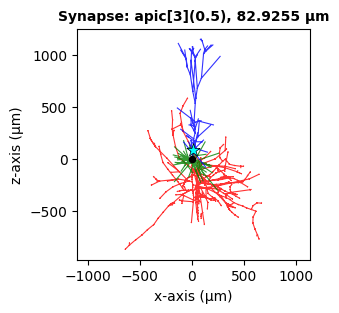

In [6]:
fig = plt.figure(figsize=(3, 3))
ax  = fig.add_subplot(111)
colors = ['r', 'g', 'b']
for i in range(3):
    ax.plot(plot_coordinates[i][0], plot_coordinates[i][2], color=colors[i], lw=0.8, alpha=0.8, zorder=-1) # x-z plane
soma_center = cell.get_section_center(cell.allSections[0])
ax.scatter(soma_center[0], soma_center[2], s=20, color='k', zorder=0)

synapse_center = cell.get_section_center(neuron.h.cell.apic[3])
ax.scatter(synapse_center[0], synapse_center[2], s=100, fc='cyan', ec='k', zorder=0, marker='*', lw=0.5)

ax.axis('equal')
# ax.axis('off')
ax.set_xlabel('x-axis (μm)', fontsize=10)
ax.set_ylabel('z-axis (μm)', fontsize=10)
ax.set_title('Synapse: apic[3](0.5), %.4f μm' % neuron.h.distance(cell.allSections[0](0.5), h.cell.apic[3](0.5)), \
            fontsize=10, weight='bold')

(-706.3416351318359, 766.9686492919922, -965.8117095947266, 1251.0777618408204)

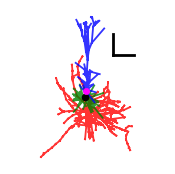

In [8]:
fig = plt.figure(figsize=(2, 2))
ax  = fig.add_subplot(111)
colors = ['r', 'g', 'b']
for i in range(3):
    ax.plot(plot_coordinates[i][0], plot_coordinates[i][2], color=colors[i], lw=1.3, alpha=0.8, zorder=-1) # x-z plane
soma_center = cell.get_section_center(cell.allSections[0])
ax.scatter(soma_center[0], soma_center[2], s=20, color='k', zorder=0)

synapse_center = cell.get_section_center(neuron.h.cell.apic[3])
ax.scatter(synapse_center[0], synapse_center[2], s=20, fc='magenta', ec=None, zorder=0, marker='o', lw=0.5)
x, y, dxy = 400, 600, 300
ax.plot([x, x+dxy], [y, y], lw=2, color='k')
ax.plot([x, x], [y, y+dxy], lw=2, color='k')

ax.axis('equal')
ax.axis('off')

# 2. Determine the synaptic input weights（prefr=50Hz, weight=0.035）

In [9]:
%%time
if not hasattr(cell, 'synapse'):
    cell.add_synapse_L5PC_Clone3()
cell.spikesource.interval = 1000/50 
cell.spikesource.start    = 1000
cell.spikesource.noise    = 1
cell.connection.weight[0] = 0.035
# run simulation to calculate firing rate
dt       = 0.05
DEL, DUR = 1e3, 2e3
tstop    = DEL + DUR + 0
tvar = np.arange(0, tstop, dt)
Evar = np.zeros_like(tvar)
cell.run_simulation_withEF(dt=dt, tstop=tstop, tvar=tvar, Evar=Evar)
t     = cell.recordings['t'].to_python()[50:]
vsoma = cell.recordings['soma(0.5)'].to_python()[50:]
t, vsoma = np.array(t), np.array(vsoma)
_, _, firingRate, spikeNumber = calcSpikeTime_spikeIndex_FiringRate_spikeNumber_fromVth(vsoma, t, Vth=0.0)
firingRate

Wall time: 1min 39s


11.49999999995879

# 3. Determine the random number seed (4784)

In [2]:
cell_name = 'L5PC_Clone3'
dataPath = r'C:/Users/Snowp/PycharmProjects/pythonProject/24_tACS_PLV/neuron_others/data/%s_phase_entrainment_40_random_seeds_1mVmm_10Hz.p' % cell_name
data = pickle.load(open(dataPath, 'rb'))
list_plv = np.array([item[0] for item in data])
list_fr  = np.array([item[5] for item in data])
np.random.seed(82412)
list_seeds = np.array(sorted(np.random.choice(np.arange(1, 5000), 40, replace=False)))

In [3]:
print('Mean plv is %.4f' % list_plv.mean())
list_diffplv = list_plv - list_plv.mean()
list_diffplv_positive = list_diffplv[list_diffplv > 0]
selected_seed = list_seeds[list_diffplv > 0][np.argmin(list_diffplv_positive)]
print('Selected seed is %d' % selected_seed)
list_seeds.tolist().index(selected_seed), list_plv[list_seeds.tolist().index(selected_seed)]

Mean plv is 0.0332
Selected seed is 4784


(35, 0.03327364643447033)

In [2]:
list_index = [[0, 100], [100, 200], [200, 300], [300, 410]]
data_410_direction = [None]*410
cell_name = 'L5PC_Clone3'
for i, idx in enumerate(list_index):
    dataPath = 'data/%s_PLV_sensitivity_to_Efield_410_directions_index%d-%d.p' % (cell_name, idx[0], idx[1])
    data = pickle.load(open(dataPath, 'rb'))
    data_410_direction[idx[0]:idx[1]] = data
plv_410_direction = np.array([item[0] for item in data_410_direction])
print('PLV min = %.4f, PLV max = %.4f' % (plv_410_direction.min(), plv_410_direction.max()))

PLV min = 0.0022, PLV max = 0.0339


(-3.141592653589793,
 3.141592653589793,
 -1.5707963267948966,
 1.5707963267948966)

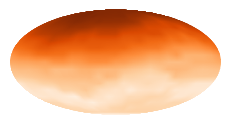

In [3]:
list_theta = np.arange(0, 181, 10)
list_phi   = np.arange(0, 361, 15)
list_theta = np.deg2rad(list_theta - 90)
list_phi   = np.deg2rad(list_phi - 180)
matrix_plv = np.zeros((len(list_theta), len(list_phi)))
matrix_plv[0, :] += plv_410_direction[0]
num = 1
for i in range(1, len(list_theta)-1):
    for j in range(len(list_phi) - 1):
        matrix_plv[i, j] = plv_410_direction[num]
        num += 1
    matrix_plv[i, -1] = plv_410_direction[num-len(list_phi) + 1]
interp_func = scipy.interpolate.interp2d(list_phi, list_theta, matrix_plv, kind='linear')
x = np.linspace(list_phi[0], list_phi[-1], 361*2)
y = np.linspace(list_theta[0], list_theta[-1], 181*2)
matrix_plv_interp = interp_func(x, y)

## plot plv-direction sensitivity
import matplotlib.colors as colors
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 2, 1, projection="mollweide")
norm = colors.Normalize(vmin=matrix_plv.min(), vmax=matrix_plv.max())
# ax.pcolormesh(list_phi, list_theta, np.flip(matrix_plv, axis=0), shading='auto', cmap='Oranges', norm=norm)
ax.pcolormesh(x, y, np.flip(matrix_plv_interp, axis=0), shading='auto', cmap='Oranges', norm=norm)

# ax.set_xticks(np.radians(np.arange(-180, 181, 60)))
# ax.set_xticklabels(['90°', '150°', '210°', '270°', '330°', '30°', '90°'])
# ax.set_yticks(np.radians(np.arange(-60, 61, 30)))
# ax.set_yticklabels(['150°', '120°', '90°', '60°', '30°'])
ax.axis('off')

(-3.141592653589793,
 3.141592653589793,
 -1.5707963267948966,
 1.5707963267948966)

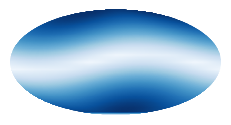

In [4]:
dataPath = 'data/%s_polarization_sensitivity_to_Efield_410_directions.p' % cell_name
data = pickle.load(open(dataPath, 'rb'))
polarization_410_direction = np.array([item[1] for item in data])
list_theta = np.arange(0, 181, 10)
list_phi   = np.arange(0, 361, 15)
list_theta = np.deg2rad(list_theta - 90)
list_phi   = np.deg2rad(list_phi - 180)
matrix_polarization = np.zeros((len(list_theta), len(list_phi)))
matrix_polarization[0, :] += polarization_410_direction[0]
num = 1
for i in range(1, len(list_theta)-1):
    for j in range(len(list_phi) - 1):
        matrix_polarization[i, j] = polarization_410_direction[num]
        num += 1
    matrix_polarization[i, -1] = polarization_410_direction[num-len(list_phi) + 1]
interp_func = scipy.interpolate.interp2d(list_phi, list_theta, matrix_polarization, kind='linear')
x = np.linspace(list_phi[0], list_phi[-1], 361*2)
y = np.linspace(list_theta[0], list_theta[-1], 181*2)
matrix_polarization_interp = interp_func(x, y)


## plot polarization-direction sensitivity
import matplotlib.colors as colors
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 2, 1, projection="mollweide")
norm = colors.Normalize(vmin=matrix_polarization_interp.min(), vmax=matrix_polarization_interp.max())
ax.pcolormesh(x, y, np.flip(matrix_polarization_interp, axis=0), shading='auto', cmap='Blues', norm=norm)

# ax.set_xticks(np.radians(np.arange(-180, 181, 60)))
# ax.set_xticklabels(['90°', '150°', '210°', '270°', '330°', '30°', '90°'])
# ax.set_yticks(np.radians(np.arange(-60, 61, 30)))
# ax.set_yticklabels(['150°', '120°', '90°', '60°', '30°'])
ax.axis('off')

0.912264420934713 0.8997314965296351 0.19474615636750758


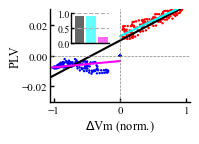

In [5]:
'''plv - polarization 相关性'''
matrix_data = matrix_polarization
value_min, value_max = matrix_data.min(), matrix_data.max()
matrix_data_norm = np.zeros_like(matrix_data)
for i in range(matrix_data.shape[0]):
    for j in range(matrix_data.shape[1]):
        matrix_data_norm[i, j] = (matrix_data[i, j] - value_min) / (value_max - value_min)
xUpward, xDownward = matrix_data_norm[:10].flatten(), matrix_data_norm[11:].flatten()
yUpward, yDownward = matrix_plv[:10].flatten(), matrix_plv[11:].flatten()
xDownward, yDownward = -xDownward, -yDownward
# 线性回归upward + downward
x = np.hstack((xDownward, xUpward))
y = np.hstack((yDownward, yUpward))
slope, intercept = np.polyfit(x, y, 1)
xfit = np.linspace(-1.05, 1.05, 2000)
yfit = slope * xfit + intercept
ypre = slope * x + intercept
R2 = 1 - np.sum((y-ypre)**2) / np.sum((y-y.mean())**2)
# 线性回归upward
x, y = xUpward, yUpward
slope, intercept = np.polyfit(x, y, 1)
xfit_upward = np.linspace(0, 1.05, 2000)
yfit_upward = slope * xfit_upward + intercept
ypre = slope * x + intercept
R2_upward = 1 - np.sum((y-ypre)**2) / np.sum((y-y.mean())**2)
# 线性回归upward
x, y = xDownward, yDownward
slope, intercept = np.polyfit(x, y, 1)
xfit_downward = np.linspace(-1.05, 0, 2000)
yfit_downward = slope * xfit_downward + intercept
ypre = slope * x + intercept
R2_downward = 1 - np.sum((y-ypre)**2) / np.sum((y-y.mean())**2)

print(R2, R2_upward, R2_downward)

# 绘图
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.2))
ax.scatter(xUpward, yUpward, s=3, fc='r', ec='none', label='upward', alpha=1)
ax.scatter(xDownward, yDownward, s=3, fc='b', ec='none', label='downward', alpha=1)
ax.plot(xfit, yfit, lw=1.5, color='k', ls='-', label='Linear')
ax.plot(xfit_upward, yfit_upward, lw=1.5, color='cyan', ls='-', alpha=1)
ax.plot(xfit_downward, yfit_downward, lw=1.5, color='magenta', ls='-', alpha=1)
ax.axvline(0, lw=0.5, ls='--', color='gray')
ax.axhline(0, lw=0.5, ls='--', color='gray')
ax.set_xlim(-1.05, 1.05)
ax.set_xticks(np.arange(-1, 1.1, 1))
ax.set_ylim(-0.03, 0.03)
# ax.set_yticks(np.arange(-0.06, 0.061, 0.06))
ax.set_xlabel(r'$\Delta$Vm (norm.)', fontsize=9, labelpad=2, fontfamily='times new roman')
ax.set_ylabel('PLV', fontsize=9, labelpad=0, fontfamily='times new roman')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', pad=2, direction='in', labelsize=8, width=1, length=3, labelfontfamily='times new roman')
# ax.set_title('$R^2=$%.3f' % R2, fontdict={'family':'times new roman'}, fontsize=9)

ax_sub = fig.add_axes([0.24, 0.6, 0.21, 0.25])
ax_sub.bar([0, 1, 2], [R2, R2_upward, R2_downward], width=0.8, color=['k', 'cyan', 'magenta'], alpha=0.6)
ax_sub.set_xlim(-0.7, 2.5)
ax_sub.set_ylim(0, 1)
ax_sub.grid(True, ls='--')
ax_sub.spines['right'].set_color('none')
ax_sub.spines['top'].set_color('none')
ax_sub.spines['bottom'].set_linewidth(1)
ax_sub.spines['left'].set_linewidth(1)
ax_sub.set_xticks([])
ax_sub.set_yticks([0, 0.5, 1])
ax_sub.tick_params(axis='both', pad=1, direction='in', labelsize=7, width=1, length=2, labelfontfamily='times new roman')
# ax_sub.axis('off')